# Chapter 5: Support Vector Machines

SVM é um algoritmo de ML versátil capaz de classificações lineares e não lineares, regressão e outlier detection. SVM é espcialmente bom para classificação de datatasets complexo mas médios/pequenos.

## Linear SVM classification

Quando duas classes são facilmente separáveis por uma linha reta são chamadas de linearmente separáveis

![](./imgs/svm1.png)

Na esquerda vemos 3 maneiras de separarmos as classes com uma linha. Um deles nem sequer separar bem. Os outros dois passam tão perto dos dados de treino que provavelmente performam mal em dados nunca vistos.

Na direita temos o SVM. Ele não apenas separa mas tenta criar a 'estrada' mais larga possível. Representada pelas linhas interrompidas paralelas. Em termos técnicos: *large margin classification*. 

Percebam: adicionar dados de treino 'fora da estrada' não vai afetar a decision boundary. Ela é completamente determinada pelas instâncias localizadas no extremo da 'estrada'. Essas instâncias são chamadas de support vectors.

SVM é muito sensível a escala!

![](./imgs/svm2.png)




### Soft Margin classification

Se a gente impõe que todas as instâncias devem ficar fora da estrada, isso é chamado de *hard margin classification*.

Existem 2 problemas com o Hard Margin:

* os dados precisam ser linearmente separáveis
* muito sensível a outliers

![](./imgs/svm3.png)

Pra evitar esses problemas é preferível usar um modelo mais flexível. O objetivo é aumentar a largura da estrada limitando a violação de margem. No sklearn SVM você controla isso usando o hiperparâmetro C. Um C pequeno leva a estradas largas mas mais violações de margem.

![](./imgs/svm4.png)

Se seu modelo SVM está overfittando, regularize-o reduzindo o C.

Vamos fitar o iris dataset

link para entender o porquê "loss = 'hinge'". Spoiler: hinge é uma loss function usada para "maximum-margin" classification 

[hinge loss](https://en.wikipedia.org/wiki/Hinge_loss)

use SGDClassifier(loss="hinge",
alpha=1/(m*C)) para datasets que n cabem na memória!

In [106]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

iris = datasets.load_iris()
X = iris['data'][:, (2, 3)] # petal length, petal width
y = (iris['target'] == 2).astype(np.float64)

svm_clf = Pipeline((
    ('scaler', StandardScaler()),
    ('linear_svc', LinearSVC(C = 1, loss = 'hinge'))
))

svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [107]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

note:

* LinearSVC regulariza o termo de bias (coeficiente linear). Assim, é importante subtrair o dataset pela média para centralizar os dados. A padronização já faz isso!

## Nonlinear SVM Classification

Alguns datasets não são linearmente separáveis. Uma forma de tentar contornar isso é adicionando mais features! Como features polinomiais. Em alguns casos isso pode gerar um dataset linearmente separável. exemplo:

![](./imgs/nlsvm.png)

O código para fazer isso é simples:

In [108]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(noise = 0.09)

polynomial_svm_clf = Pipeline((
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge"))
))
polynomial_svm_clf.fit(X, y)
pass

In [109]:
from mlxtend.plotting import plot_decision_regions

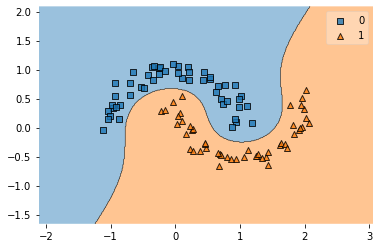

In [110]:
plot_decision_regions(X, y, clf = polynomial_svm_clf)

### Polynomial kernel

Adicionar features polinomiais é simples e pode funcionar bem com muitos modelos de ML. O problema é que baixos graus podem não ser suficientes e altos graus podem tornar o processo lento.

Ao usar SVM existe uma matemágica chamada *Kernel trick* que possibilita ter o mesmo resultado de adicionar varias features polinomiais sem precisar adicioná-las de verdade.

In [111]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline((
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
))

poly_kernel_svm_clf.fit(X, y)
pass

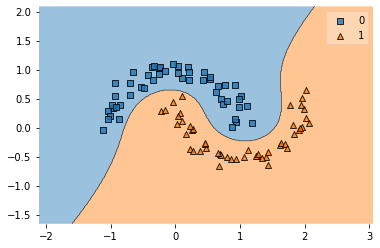

In [112]:
plot_decision_regions(X, y, clf = poly_kernel_svm_clf)

A common approach to find the right hyperparameter values is to use grid search (see Chapter 2). It is often faster to first do a very coarse grid search, then a finer grid search around the best values found. Having a good sense of what each hyperparameter actually does can also help you  search in the right part of the hyperparameter space.

### adding similarity features

Uma outra técnica para problemas não lineares é adicionar features usando a *similarity function* que mede quanto cada instância se assemelha de um ponto de referência.

pense no dataset 1 dimensional:

![](./imgs/uni.png)

agora pense em 2 pontos de referência: $x_1 = -2$ e $x_1 = 1$. Agora definimos a função de similaridade sendo uma função de base radial - (RBF: radial basis function - seu valor só depende da distância até a origem) gaussiana.

Nossa RBF gaussiana:

$$
\phi\gamma(\pmb x, l) = exp(-\gamma||\pmb x - l||^2)
$$

É uma função que vai de 0 (quando está muito distante do ponto de referência) até 1 (quando está no ponto de referência).

Usando $\gamma = 0.3$, para o ponto $x_1 = -1$ criamos as features $x_2 = exp(-0.3 \cdot 1^2) \approx 0.74$ e $x_3 = exp(-0.3 \cdot 2^2) \approx 0.30$

Agora aplicamos isso para todas as instâncias e jogamos fora a feature original

![](./imgs/ls.png)

Como selecionar pontos de referência? A abordagem mais simples é: coloca um em cada ponto do dataset. Isso vai criar muitas dimensões e aumentar as chances de criar features linearmente separáveis. O lado ruim é que você cria 1 feature para cada instância, podendo gerar um dataset muito pesado / grande.




### Gaussian RBF kernel

É isso galera, não precisa criar milhões de colunas graças a matemágica.

código:

In [113]:
rbf_kernel_svm_clf = Pipeline((
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=0.1, C=1000))
))
rbf_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.1,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

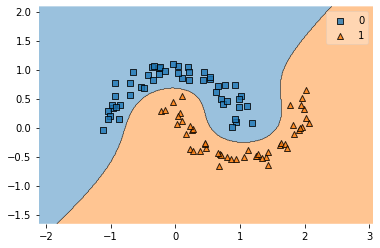

In [114]:
plot_decision_regions(X, y, clf = rbf_kernel_svm_clf)

With so many kernels to choose from, how can you decide which one to use?

As a rule of thumb, you should always try the linear kernel first (remember that LinearSVC is much faster than SVC (kernel="linear")), especially if the training set is very large or if it has plenty of features. 

If the training set is not too large, you should try the Gaussian RBF kernel as well; it works well in most cases. 

Then if you have spare time and computing power, you can also experiment with a few other kernels using cross-validation and gridsearch, especially if there are kernels specialized for your training set’s data structure.

## SVM Regression

Para a regressão é feito um truque parecido com o de classificação, mas o truque é invertido: ao invés de tentar deixar todos os pontos fora da estrada e deixar a estrada o mais larga possível, na regressão queremos todos os pontos na estrada com a menor largura possível. A largura é controlada por um hiperparâmetro $\epsilon$.

In [168]:
X = np.linspace(-1, 1, 100).reshape(-1, 1)
y = X**2 + 0.1*X + 0.5*np.random.rand(X.shape[0], X.shape[1])

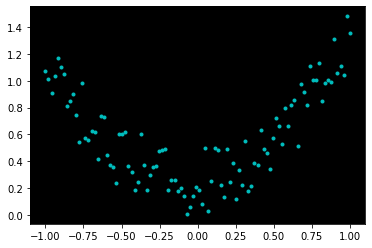

In [169]:
plt.plot(X,y, 'c.')
ax = plt.gca()
ax.set_facecolor((0,0,0))

In [170]:
from sklearn.svm import SVR
svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y)

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1,
    gamma='auto_deprecated', kernel='poly', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

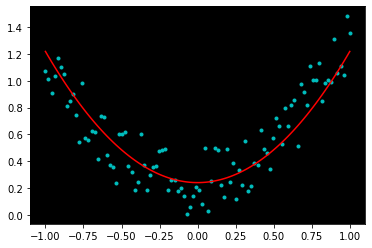

In [171]:
plt.plot(X,y, 'c.')
plt.plot(X, svm_poly_reg.predict(X), 'r-')
ax = plt.gca()
ax.set_facecolor((0,0,0))

## Under the hood

Convenção:

* *b* é termo de bias 
* $\pmb w$ é o vetor de pesos

### Decision function e predições

O modelo linear de classificação SVM prevê a classe de uma nova instância simplesmente computando a função de decisão $\pmb w^T\cdot \pmb x + b$. Se o resultado é positivo, pertence a uma classe, se negativo, pertence a outra.

$$
 \hat y = \begin{cases} 
      0 & \pmb w^T\cdot \pmb x + b\lt 0 \\
      1 & \pmb w^T\cdot \pmb x + b\geq 0 \\
   \end{cases}
$$

Como a gente pode ver se trata de uma função linear então estamos falando de pontos, retas, planos e hiper-planos. Ok?

Atendendo as expectativas, a decision boundary ocorre na igualdade.

Treinar uma SVM é criar a estrada mais larga possível evitando violação de margem parcial ou totalmente.

### Objetivo do treino

Como se trata de uma função linear, o declínio do nosso plano/reta é a norma do vetor $\pmb w$. Ou seja:$||\pmb w||$. Exemplo:

para uma reta: $y = a\cdot x+b$, o declínio é $a$

para um plano: $y = a\cdot x_1 + b\cdot x_2 + c$, o declínio é o gradiente que é $(a,b)$ e seu móduto é $\sqrt{a^2 + b^2} = ||\pmb w||$

![](./imgs/db.png)

Se a gente divide nosso declínio por 2, os pontos onde a função de decisão são iguais a 1 vão ficar 2x mais distantes da decision boundary.

Em outras palavras: menor declínio $\implies$ maior margem

Visualização no plano 2d:

![](./imgs/2d.png)

Então a gente quer minimizar $||\pmb w||$ para conseguir uma margem maior! Veja que para manter todos os dados fora da margem é necessário estreitá-la. A condição matemática para manter todo mundo fora é dada por:

$$
t^{(i)}(\pmb w^T \cdot \pmb x^{(i)} + b) \ge 1
$$

* $t^{(i)}$ é -1 para instâncias negativas (classe ŷ = 0) e 1 para as positivas (classe ŷ = 1)

Assim, nosso problema final se resume a:

$$
\min_{\pmb w, b}  \frac{1}{2}\pmb w^T \cdot \pmb w
$$

com a condição $t^{(i)}(\pmb w^T \cdot \pmb x^{(i)} + b) \ge 1$ $\space \forall i = 1, 2, ..., m$

minimizamos o quadrado do módulo pq é muito mais fácil, né seus corno. É diferenciável e tal. Só o filé!

Para conseguir uma margem suave (soft margin) precisamos introduzir uma variável de folga $\zeta ^{(i)} \ge 0$ para cada instância. Essa variável vai medir quanto cada instância pode violar a margem.

Agora temos dois objetivos conflitantes: fazer com que as variáveis de folga sejam pequenas reduzindo a violação de margem e fazer com que o módulo de $\pmb w$ seja o menor possível para ter a margem mais larga possível.

Aqui que entra nosso hyperametro C! Ele nos deixa definir o trade-off entre esses dois objetivos!

Assim, nosso problema final é:

$$
\min_{\pmb w, b, \zeta} \frac{1}{2}\pmb w^T \cdot \pmb w + C \sum_{i = 1}^m \zeta ^{(i)}
$$

com a condição:

$$
t^{(i)}(\pmb w^T \cdot \pmb x^{(i)} + b) \ge 1-\zeta^{(i)} 
$$
$$
with \: \zeta^{(i)} \ge 0 \:and\: \forall i = 1, 2, ..., m 
$$

### Programação quadrática

O problema de soft e hard margin são problemas de otimização de funções quadráticas convexas com constraints lineares.

Problemas assim são chamados de problemas de programação quadrática (QP problems). As técnicas de solução fogem do escopo do livro e, portanto, fogem do nosso também.

### The dual problem

É possível expressar um problema primário de otimização com constraints por um problema parecido. Esse é chamado de Dual problem.

A solução do problema dual normalmente dá um limite inferior para a solução do problema original mas sob algumas condições pode resultar na mesma solução. Em SVM essas condições são satisfeitas então você pode escolher entre resolver o problema principal ou o dual. Os dois terão a mesma solução.

O problema dual é mais rápido de resolver que o primário quando o número de instâncias de treino é menor que o de features. 

Mais importante: ele permite a matemágica por trás do kernel trick.

### Kernelized SVM

Suponha que vc quer aplicar uma transformação polinomial em um dataset 2D. Assim a função que você usa pra transformar faz o seguinte:

$$
\phi(\pmb x) = \phi(\begin{bmatrix} 
                    x_1\\
                    x_2\\
                    \end{bmatrix})
                    = \begin{bmatrix} 
                    x_1^2\\
                    \sqrt 2 x_1 x_2\\
                    x_2^2\\
                    \end{bmatrix}
$$

Veja que o vetor de saída é 3D e nao 2D.

Agora vocês vão ter que acreditar em mim porque eu não sou corno de colocar a conta aqui mas dados dois vetores $\pmb a$ e $\pmb b$, segue a seguinte propriedade:

$$
\phi(\pmb a)^T \cdot \phi(\pmb b) = (\pmb a^T \cdot \pmb b)^2
$$

Essa é a jogada principal do truque do kernel. Se você aplica $\phi$ para todo o dataset, o problema dual vai contar esse produto vetorial acima. Mas você consegue substituílo pelo produto vetorial do lado direito da equação! Ou seja, você não precisa transformar os dados de verdade.

Assim, o truque de kernel é matematicamente lindo e salva um tempo computacional desgraçado.

fotinha dos kernels mais comuns:

![](./imgs/kernels.png)

quiser saber mais dessa mat por trás disso procure por "Mercer’s Theorem"

### Online SVMs


Para o linear SVM classifier, usa-se GD para minimizar a função de custo que é derivada do problema primário, infelizmente converge bem mais devagar que usando técnicas de QP problems.

função de custo:

$$
J(\pmb w, b) = \frac{1}{2}\pmb w^T\cdot \pmb w + C\sum_{i=1}^m max(0, 1-t^{(i)}(\pmb w^T \cdot x^{(i)} + b))
$$

A primeira parcela é a que tenta aumentar a largura da estrada. A segunda computa o total de violação de margem. É zero se tá fora da estrada ou é proporcional a distância do lado correto da estrada.

A segunda parcela é chamada de hinge loss function.

Bom, para problemas não lineares de grande escala nós abandonamos SVM e usamos redes neurais!

## Exercises

1. Qual a principal ideia do SVM?

Separar classes com uma 'estrada' o mais larga possível.

2. O que é um support vector?

São os dois dados de classes distintas mais próximos que sevem como suporte para a construção da estrada. Todos os outros dados são irrelevantes na construção do modelo.

3. por que é importante escalonar/padronizar os dados pra usar SVM?

Porque o SVM trabalha muito com a distância, se não tiver escalado ele vai acabar negligenciando features menores.

4. Um SVM pode dar um score de confiança para uma predição?

Sim, baseado na distância da instância até a decision boundary. Porém, por si só isso não é um probabilidade. Se quiser colocar probabilidade no meio dessa brincadeira tem que usar regressão logística.

5. Melhor usar o primal problem ou o dual problem para milhares de instâncias e centenas de features?

primal problem

6. Você treinou um SVM usando um kernel RBF. Ele parece estar underfittando o treino. Você aumenta ou diminui o hiperparâmetro $\gamma$? E o C?

O que você precisa, de verdade, é diminuir a regularização. Isso você faz aumentando qualquer um dos dois hiperparâmetros. Ou até mesmo os dois.



As proximas questões ou são código (8, 9, 10) ou fogem do escopo(7).
